In [4]:
# Restormer-Tiny Super-Resolution on DIV2K
# Simplified version for 2x Super-Resolution, memory-efficient

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# ============ Utility ============
def window_partition(x, window_size):
    B, C, H, W = x.shape
    x = x.view(B, C, H // window_size, window_size, W // window_size, window_size)
    windows = x.permute(0, 2, 4, 1, 3, 5).contiguous().view(-1, C, window_size, window_size)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, -1, window_size, window_size)
    x = x.permute(0, 3, 1, 4, 2, 5).contiguous().view(B, -1, H, W)
    return x



In [3]:
# ============ Transformer Block with Local Attention ============
class LayerNorm2d(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        mu = x.mean(1, keepdim=True)
        var = x.var(1, keepdim=True, unbiased=False)
        x = (x - mu) / torch.sqrt(var + self.eps)
        return self.gamma * x + self.beta

class MDTA(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Conv2d(dim, dim * 3, 1)
        self.proj = nn.Conv2d(dim, dim, 1)
        self.window_size = window_size

    def forward(self, x):
        B, C, H, W = x.shape
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = F.pad(x, (0, pad_w, 0, pad_h))
        _, _, H_pad, W_pad = x.shape

        windows = window_partition(x, self.window_size)  # [num_windows*B, C, ws, ws]
        qkv = self.qkv(windows).reshape(-1, 3, self.heads, C // self.heads, self.window_size * self.window_size)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]

        attn = (q.transpose(-2, -1) @ k) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v.transpose(-2, -1)).transpose(-2, -1)
        out = out.reshape(-1, C, self.window_size, self.window_size)

        x = window_reverse(out, self.window_size, H_pad, W_pad)
        x = x[:, :, :H, :W]  # remove padding
        return self.proj(x)

class GatedFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Conv2d(dim, dim * 2, 1)
        self.dwconv = nn.Conv2d(dim * 2, dim * 2, 3, 1, 1, groups=dim * 2)
        self.fc2 = nn.Conv2d(dim, dim, 1)

    def forward(self, x):
        x1 = self.fc1(x)
        x1 = self.dwconv(x1)
        x1_1, x1_2 = x1.chunk(2, dim=1)
        x = x1_1 * torch.sigmoid(x1_2)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = LayerNorm2d(dim)
        self.attn = MDTA(dim)
        self.norm2 = LayerNorm2d(dim)
        self.ffn = GatedFFN(dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x



In [4]:
# ============ Restormer-Tiny ============
class RestormerTiny(nn.Module):
    def __init__(self, dim=32, num_blocks=4, scale=2):
        super().__init__()
        self.shallow_feat = nn.Conv2d(3, dim, kernel_size=3, padding=1)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(dim) for _ in range(num_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(dim, dim * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.Conv2d(dim, 3, 3, 1, 1)
        )

    def forward(self, x):
        x = self.shallow_feat(x)
        x = self.transformer_blocks(x)
        x = self.upsample(x)
        return x



In [5]:
# ============ DIV2K Dataset ============
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale=2, transform=None):
        super().__init__()
        self.hr_images = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(".png")]
        self.scale = scale
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        w, h = hr.size
        hr = hr.crop((0, 0, w - w % self.scale, h - h % self.scale))
        lr = hr.resize((w // self.scale, h // self.scale), Image.BICUBIC)
        return self.transform(lr), self.transform(hr)



In [ ]:
# # ============ Training and Visualization ============
# def train(model, dataloader, device):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#     criterion = nn.MSELoss()
#     model.train()
#     for epoch in range(5):
#         loss_total = 0
#         for lr, hr in dataloader:
#             lr, hr = lr.to(device), hr.to(device)
#             sr = model(lr)
#             loss = criterion(sr, hr)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             loss_total += loss.item()
#         print(f"Epoch {epoch + 1}, Loss: {loss_total / len(dataloader):.4f}")



In [48]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
from torchmetrics.functional import structural_similarity_index_measure as compute_ssim

def psnr(target, output, data_range=1.0):
    mse = np.mean((target - output) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(data_range / np.sqrt(mse))

def evaluate(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for lr_img, hr_img in dataloader:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            sr_img = model(lr_img).clamp(0.0, 1.0)
            
            psnr_val = psnr(hr_img.squeeze().cpu().numpy(), sr_img.squeeze().cpu().numpy())
            ssim_val = compute_ssim(sr_img, hr_img, data_range=1.0).item()
            
            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)

    return (
        sum(psnr_scores) / len(psnr_scores),
        sum(ssim_scores) / len(ssim_scores)
    )


def plot_learning_curve(epoch_losses, epoch_psnrs, epoch_ssims):
    plt.figure(figsize=(18, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)

    # Plot PSNR
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(epoch_psnrs) + 1), epoch_psnrs, label='Validation PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.title('Validation PSNR Curve')
    plt.legend()
    plt.grid(True)

    # Plot SSIM
    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(epoch_ssims) + 1), epoch_ssims, label='Validation SSIM', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('Validation SSIM Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



def train(model, train_dataloader, val_dataloader, epochs=2, lr=1e-4, log_dir="runs/restormerTry"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    writer = SummaryWriter(log_dir)

    epoch_losses = []
    epoch_psnrs = []
    epoch_ssims = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for lr_img, hr_img in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)

            output = model(lr_img)
            loss = criterion(output, hr_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        writer.add_scalar("Loss/Train", avg_loss, epoch)

        val_psnr, val_ssim = evaluate(model, val_dataloader)
        epoch_psnrs.append(val_psnr)
        epoch_ssims.append(val_ssim)
        writer.add_scalar("PSNR/Val", val_psnr, epoch)
        writer.add_scalar("SSIM/Val", val_ssim, epoch)

        # log images (first batch only)
        model.eval()
        with torch.no_grad():
            for lr_img, hr_img in val_dataloader:
                lr_img = lr_img.to(device)
                sr_img = model(lr_img).clamp(0.0, 1.0)
                writer.add_images("Input/LR", lr_img, epoch)
                writer.add_images("Output/SR", sr_img, epoch)
                writer.add_images("Target/HR", hr_img.to(device), epoch)
                break

        # Clear GPU cache after each epoch
        torch.cuda.empty_cache()

        # Optional: monitor memory usage
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1e6
            reserved = torch.cuda.memory_reserved() / 1e6
            print(f"[GPU] Memory allocated: {allocated:.2f} MB | reserved: {reserved:.2f} MB")

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    writer.close()
    plot_learning_curve(epoch_losses, epoch_psnrs, epoch_ssims)
    return model


In [30]:
import cv2
import numpy as np
import torchvision.transforms as transforms

def visualize_cv2(model, dataloader, device):
    model.eval()
    lr, hr = next(iter(dataloader))
    lr_tensor = lr.to(device)

    with torch.no_grad():
        sr = model(lr_tensor).cpu()

    # Take one sample from the batch
    for i in range(min(1, lr_tensor.size(0))):
        sr_img = transforms.ToPILImage()(sr[i].clamp(0, 1))
        hr_img = transforms.ToPILImage()(hr[i])
        lr_img = transforms.ToPILImage()(lr[i])

        # Convert PIL to NumPy (BGR for OpenCV)
        sr_bgr = cv2.cvtColor(np.array(sr_img), cv2.COLOR_RGB2BGR)
        hr_bgr = cv2.cvtColor(np.array(hr_img), cv2.COLOR_RGB2BGR)
        lr_bgr = cv2.cvtColor(np.array(lr_img), cv2.COLOR_RGB2BGR)

        # Optionally resize LR image to HR size for better viewing
        lr_resized = cv2.resize(lr_bgr, (hr_bgr.shape[1], hr_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Show in separate windows
        cv2.imshow('Low-Resolution', lr_resized)
        cv2.imshow('Super-Resolved', sr_bgr)
        cv2.imshow('High-Resolution', hr_bgr)

        cv2.waitKey(0)
        cv2.destroyAllWindows()




In [43]:
    # Transform to convert images to tensors
transform = transforms.Compose([
        transforms.ToTensor()
])
    # Load the full dataset (800 images assumed)
train_dataset = DIV2KDataset("./DIV2K_train_HR_Cropped", transform=transform, scale=2)
val_dataset = DIV2KDataset("./DIV2K_valid_HR_Cropped", transform=transform, scale=2)

train_size = int(len(train_dataset))  # 800
val_size = int(len(val_dataset))  # 100

    # Dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1)


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RestormerTiny(dim=32, num_blocks=4, scale=2).to(device)

In [45]:
def check_memory_usage():
    import torch
    print(f"Allocated VRAM: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved VRAM:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")
def clear_cpu_cache():
    import torch
    import gc
# Delete all PyTorch objects
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def clear_gpu_cache():
    import torch
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


In [46]:
check_memory_usage()
clear_cpu_cache()
clear_gpu_cache()
check_memory_usage()

Allocated VRAM: 0.25 GB
Reserved VRAM:  0.83 GB
Allocated VRAM: 0.25 GB
Reserved VRAM:  0.83 GB


Epoch 1: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 297.57 MB | reserved: 828.38 MB
Epoch 1: Loss = 0.0041, PSNR = 27.02, SSIM = 0.8041


Epoch 2: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 2: Loss = 0.0026, PSNR = 28.42, SSIM = 0.8447


Epoch 3: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 3: Loss = 0.0021, PSNR = 29.14, SSIM = 0.8620


Epoch 4: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 4: Loss = 0.0019, PSNR = 29.47, SSIM = 0.8712


Epoch 5: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 5: Loss = 0.0019, PSNR = 29.80, SSIM = 0.8763


Epoch 6: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 6: Loss = 0.0017, PSNR = 29.89, SSIM = 0.8782


Epoch 7: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 7: Loss = 0.0017, PSNR = 30.16, SSIM = 0.8837


Epoch 8: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 8: Loss = 0.0017, PSNR = 30.30, SSIM = 0.8856


Epoch 9: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 9: Loss = 0.0017, PSNR = 30.37, SSIM = 0.8880


Epoch 10: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 10: Loss = 0.0016, PSNR = 30.46, SSIM = 0.8889


Epoch 11: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 11: Loss = 0.0016, PSNR = 30.49, SSIM = 0.8899


Epoch 12: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 12: Loss = 0.0016, PSNR = 30.37, SSIM = 0.8911


Epoch 13: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 13: Loss = 0.0016, PSNR = 30.62, SSIM = 0.8908


Epoch 14: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 14: Loss = 0.0016, PSNR = 30.39, SSIM = 0.8926


Epoch 15: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 15: Loss = 0.0016, PSNR = 30.41, SSIM = 0.8870


Epoch 16: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 16: Loss = 0.0016, PSNR = 30.66, SSIM = 0.8940


Epoch 17: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 17: Loss = 0.0016, PSNR = 30.17, SSIM = 0.8898


Epoch 18: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 18: Loss = 0.0016, PSNR = 30.80, SSIM = 0.8948


Epoch 19: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 19: Loss = 0.0015, PSNR = 30.81, SSIM = 0.8954


Epoch 20: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 20: Loss = 0.0015, PSNR = 30.73, SSIM = 0.8950


Epoch 21: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 21: Loss = 0.0015, PSNR = 30.74, SSIM = 0.8936


Epoch 22: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 22: Loss = 0.0016, PSNR = 30.50, SSIM = 0.8902


Epoch 23: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 23: Loss = 0.0015, PSNR = 30.86, SSIM = 0.8967


Epoch 24: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 24: Loss = 0.0015, PSNR = 30.87, SSIM = 0.8966


Epoch 25: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 25: Loss = 0.0015, PSNR = 30.70, SSIM = 0.8962


Epoch 26: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 26: Loss = 0.0015, PSNR = 30.91, SSIM = 0.8974


Epoch 27: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 27: Loss = 0.0015, PSNR = 30.87, SSIM = 0.8975


Epoch 28: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 28: Loss = 0.0015, PSNR = 30.87, SSIM = 0.8979


Epoch 29: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 29: Loss = 0.0015, PSNR = 30.78, SSIM = 0.8981


Epoch 30: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 30: Loss = 0.0015, PSNR = 30.80, SSIM = 0.8979


Epoch 31: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 31: Loss = 0.0015, PSNR = 30.80, SSIM = 0.8960


Epoch 32: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 32: Loss = 0.0015, PSNR = 30.98, SSIM = 0.8986


Epoch 33: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 33: Loss = 0.0015, PSNR = 30.96, SSIM = 0.8986


Epoch 34: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 34: Loss = 0.0015, PSNR = 30.89, SSIM = 0.8982


Epoch 35: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 35: Loss = 0.0015, PSNR = 31.00, SSIM = 0.8991


Epoch 36: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 36: Loss = 0.0015, PSNR = 31.00, SSIM = 0.8991


Epoch 37: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 37: Loss = 0.0015, PSNR = 30.99, SSIM = 0.8989


Epoch 38: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 38: Loss = 0.0015, PSNR = 30.18, SSIM = 0.8968


Epoch 39: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 39: Loss = 0.0015, PSNR = 30.95, SSIM = 0.8987


Epoch 40: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 40: Loss = 0.0015, PSNR = 31.00, SSIM = 0.8995


Epoch 41: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 41: Loss = 0.0015, PSNR = 30.48, SSIM = 0.8943


Epoch 42: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 42: Loss = 0.0015, PSNR = 30.99, SSIM = 0.8992


Epoch 43: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 43: Loss = 0.0015, PSNR = 31.03, SSIM = 0.8997


Epoch 44: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 44: Loss = 0.0015, PSNR = 31.01, SSIM = 0.8997


Epoch 45: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 45: Loss = 0.0015, PSNR = 30.92, SSIM = 0.8981


Epoch 46: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 46: Loss = 0.0015, PSNR = 31.03, SSIM = 0.9000


Epoch 47: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 47: Loss = 0.0015, PSNR = 30.97, SSIM = 0.9000


Epoch 48: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 48: Loss = 0.0015, PSNR = 30.39, SSIM = 0.8960


Epoch 49: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 49: Loss = 0.0015, PSNR = 31.00, SSIM = 0.8992


Epoch 50: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 50: Loss = 0.0015, PSNR = 30.63, SSIM = 0.8993


Epoch 51: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 51: Loss = 0.0015, PSNR = 31.06, SSIM = 0.9004


Epoch 52: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 52: Loss = 0.0015, PSNR = 30.92, SSIM = 0.8990


Epoch 53: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 53: Loss = 0.0015, PSNR = 31.05, SSIM = 0.8996


Epoch 54: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 54: Loss = 0.0015, PSNR = 30.94, SSIM = 0.9007


Epoch 55: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 55: Loss = 0.0015, PSNR = 31.09, SSIM = 0.9007


Epoch 56: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 56: Loss = 0.0015, PSNR = 30.97, SSIM = 0.9001


Epoch 57: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 57: Loss = 0.0015, PSNR = 31.10, SSIM = 0.9007


Epoch 58: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 58: Loss = 0.0015, PSNR = 31.04, SSIM = 0.8996


Epoch 59: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 59: Loss = 0.0015, PSNR = 31.12, SSIM = 0.9009


Epoch 60: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 60: Loss = 0.0015, PSNR = 30.98, SSIM = 0.9001


Epoch 61: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 61: Loss = 0.0015, PSNR = 31.13, SSIM = 0.9012


Epoch 62: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 62: Loss = 0.0015, PSNR = 31.14, SSIM = 0.9012


Epoch 63: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 63: Loss = 0.0015, PSNR = 31.15, SSIM = 0.9012


Epoch 64: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 64: Loss = 0.0015, PSNR = 31.13, SSIM = 0.9012


Epoch 65: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 65: Loss = 0.0015, PSNR = 31.15, SSIM = 0.9009


Epoch 66: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 66: Loss = 0.0015, PSNR = 30.81, SSIM = 0.8993


Epoch 67: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 67: Loss = 0.0015, PSNR = 31.17, SSIM = 0.9015


Epoch 68: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 68: Loss = 0.0015, PSNR = 31.08, SSIM = 0.9014


Epoch 69: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 69: Loss = 0.0015, PSNR = 31.18, SSIM = 0.9014


Epoch 70: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 70: Loss = 0.0014, PSNR = 31.17, SSIM = 0.9018


Epoch 71: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 71: Loss = 0.0014, PSNR = 31.17, SSIM = 0.9009


Epoch 72: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 72: Loss = 0.0015, PSNR = 29.67, SSIM = 0.8989


Epoch 73: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 73: Loss = 0.0015, PSNR = 31.21, SSIM = 0.9021


Epoch 74: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 74: Loss = 0.0014, PSNR = 31.20, SSIM = 0.9018


Epoch 75: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 75: Loss = 0.0015, PSNR = 31.22, SSIM = 0.9021


Epoch 76: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 76: Loss = 0.0014, PSNR = 31.24, SSIM = 0.9022


Epoch 77: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 77: Loss = 0.0014, PSNR = 31.20, SSIM = 0.9021


Epoch 78: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 78: Loss = 0.0014, PSNR = 31.22, SSIM = 0.9010


Epoch 79: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 79: Loss = 0.0014, PSNR = 31.20, SSIM = 0.9017


Epoch 80: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 80: Loss = 0.0014, PSNR = 31.27, SSIM = 0.9025


Epoch 81: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 81: Loss = 0.0014, PSNR = 31.23, SSIM = 0.9026


Epoch 82: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 82: Loss = 0.0014, PSNR = 31.27, SSIM = 0.9023


Epoch 83: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 83: Loss = 0.0014, PSNR = 31.27, SSIM = 0.9028


Epoch 84: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 84: Loss = 0.0014, PSNR = 31.31, SSIM = 0.9029


Epoch 85: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 85: Loss = 0.0014, PSNR = 31.27, SSIM = 0.9030


Epoch 86: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 86: Loss = 0.0014, PSNR = 31.25, SSIM = 0.9026


Epoch 87: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 87: Loss = 0.0014, PSNR = 31.33, SSIM = 0.9032


Epoch 88: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 88: Loss = 0.0014, PSNR = 31.34, SSIM = 0.9031


Epoch 89: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 89: Loss = 0.0014, PSNR = 31.36, SSIM = 0.9036


Epoch 90: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 90: Loss = 0.0014, PSNR = 31.27, SSIM = 0.9020


Epoch 91: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 91: Loss = 0.0014, PSNR = 31.38, SSIM = 0.9039


Epoch 92: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 92: Loss = 0.0014, PSNR = 31.34, SSIM = 0.9034


Epoch 93: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 93: Loss = 0.0014, PSNR = 31.39, SSIM = 0.9035


Epoch 94: 100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 94: Loss = 0.0014, PSNR = 31.24, SSIM = 0.9034


Epoch 95: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 95: Loss = 0.0014, PSNR = 30.76, SSIM = 0.9038


Epoch 96: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 96: Loss = 0.0014, PSNR = 31.41, SSIM = 0.9039


Epoch 97: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 97: Loss = 0.0014, PSNR = 31.39, SSIM = 0.9043


Epoch 98: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 98: Loss = 0.0014, PSNR = 31.41, SSIM = 0.9043


Epoch 99: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.31 MB | reserved: 828.38 MB
Epoch 99: Loss = 0.0014, PSNR = 31.05, SSIM = 0.9007


Epoch 100: 100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


[GPU] Memory allocated: 298.33 MB | reserved: 828.38 MB
Epoch 100: Loss = 0.0014, PSNR = 31.40, SSIM = 0.9046


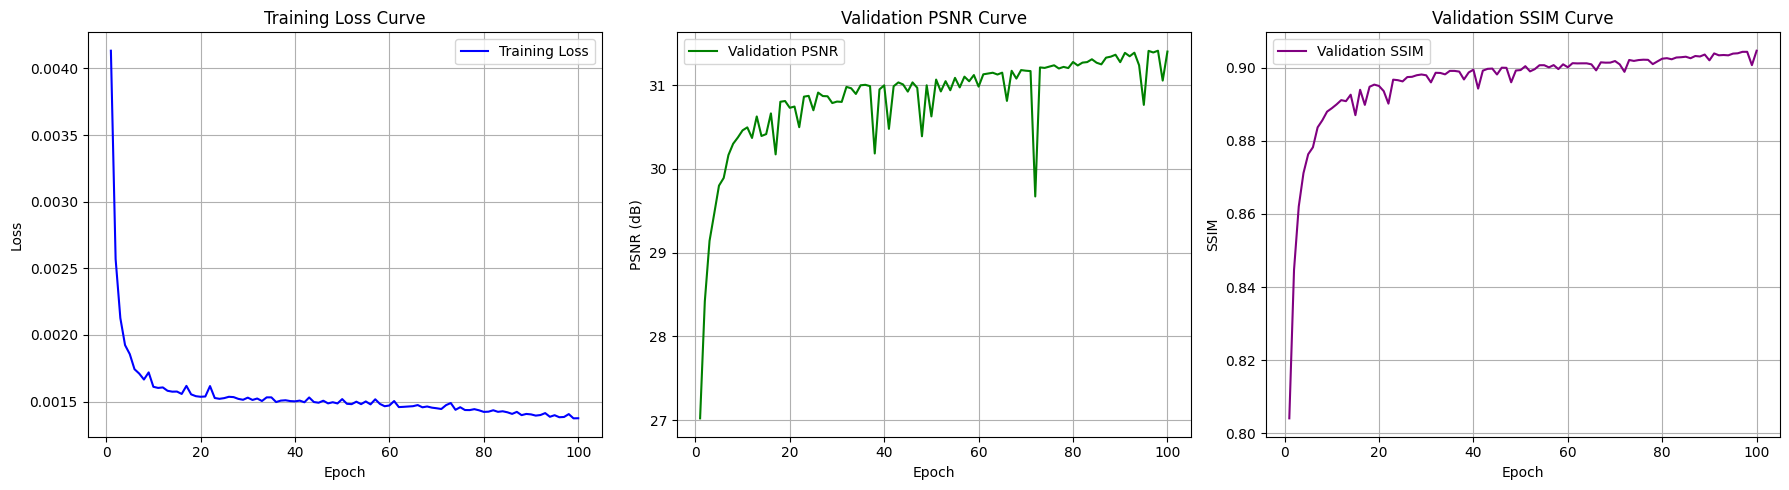

RestormerTiny(
  (shallow_feat): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm2d()
      (attn): MDTA(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
        (proj): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm2): LayerNorm2d()
      (ffn): GatedFFN(
        (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (dwconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (fc2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm2d()
      (attn): MDTA(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
        (proj): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm2): LayerNorm2d()
      (ffn): GatedFFN(
        (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (dwconv): Conv2d(64,

In [50]:
train(model, train_loader, val_loader, epochs=100, lr=1e-4, log_dir="runs/RestormerTiny")

In [51]:
torch.save(model.state_dict(), "restormer_tiny.pth")

# Inference

In [5]:
def window_partition(x, window_size):
    B, C, H, W = x.shape
    x = x.view(B, C, H // window_size, window_size, W // window_size, window_size)
    windows = x.permute(0, 2, 4, 1, 3, 5).contiguous().view(-1, C, window_size, window_size)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, -1, window_size, window_size)
    x = x.permute(0, 3, 1, 4, 2, 5).contiguous().view(B, -1, H, W)
    return x



In [6]:
# ============ Transformer Block with Local Attention ============
class LayerNorm2d(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        mu = x.mean(1, keepdim=True)
        var = x.var(1, keepdim=True, unbiased=False)
        x = (x - mu) / torch.sqrt(var + self.eps)
        return self.gamma * x + self.beta

class MDTA(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Conv2d(dim, dim * 3, 1)
        self.proj = nn.Conv2d(dim, dim, 1)
        self.window_size = window_size

    def forward(self, x):
        B, C, H, W = x.shape
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = F.pad(x, (0, pad_w, 0, pad_h))
        _, _, H_pad, W_pad = x.shape

        windows = window_partition(x, self.window_size)  # [num_windows*B, C, ws, ws]
        qkv = self.qkv(windows).reshape(-1, 3, self.heads, C // self.heads, self.window_size * self.window_size)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]

        attn = (q.transpose(-2, -1) @ k) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v.transpose(-2, -1)).transpose(-2, -1)
        out = out.reshape(-1, C, self.window_size, self.window_size)

        x = window_reverse(out, self.window_size, H_pad, W_pad)
        x = x[:, :, :H, :W]  # remove padding
        return self.proj(x)

class GatedFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Conv2d(dim, dim * 2, 1)
        self.dwconv = nn.Conv2d(dim * 2, dim * 2, 3, 1, 1, groups=dim * 2)
        self.fc2 = nn.Conv2d(dim, dim, 1)

    def forward(self, x):
        x1 = self.fc1(x)
        x1 = self.dwconv(x1)
        x1_1, x1_2 = x1.chunk(2, dim=1)
        x = x1_1 * torch.sigmoid(x1_2)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = LayerNorm2d(dim)
        self.attn = MDTA(dim)
        self.norm2 = LayerNorm2d(dim)
        self.ffn = GatedFFN(dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x



In [7]:
# ============ Restormer-Tiny ============
class RestormerTiny(nn.Module):
    def __init__(self, dim=32, num_blocks=4, scale=2):
        super().__init__()
        self.shallow_feat = nn.Conv2d(3, dim, kernel_size=3, padding=1)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(dim) for _ in range(num_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(dim, dim * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.Conv2d(dim, 3, 3, 1, 1)
        )

    def forward(self, x):
        x = self.shallow_feat(x)
        x = self.transformer_blocks(x)
        x = self.upsample(x)
        return x



In [9]:
# ============ DIV2K Dataset ============
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale=2, transform=None):
        super().__init__()
        self.hr_images = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(".png")]
        self.scale = scale
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        w, h = hr.size
        hr = hr.crop((0, 0, w - w % self.scale, h - h % self.scale))
        lr = hr.resize((w // self.scale, h // self.scale), Image.BICUBIC)
        return self.transform(lr), self.transform(hr)



In [8]:
model = RestormerTiny(dim=32, num_blocks=4, scale=2)
model.load_state_dict(torch.load("restormer_tiny.pth"))
model.eval()


RestormerTiny(
  (shallow_feat): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm2d()
      (attn): MDTA(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
        (proj): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm2): LayerNorm2d()
      (ffn): GatedFFN(
        (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (dwconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (fc2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm2d()
      (attn): MDTA(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
        (proj): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm2): LayerNorm2d()
      (ffn): GatedFFN(
        (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (dwconv): Conv2d(64,

In [10]:
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = DIV2KDataset("./comparison_images", transform=transform, scale=2)

    # Dataloaders
val_loader = DataLoader(full_dataset, batch_size=1)

In [11]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"Restormer-Tinylr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"Restormer-Tinysr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"Restormer-Tinyhr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 38.55 dB
SSIM: 0.9643
Example 2
PSNR: 38.60 dB
SSIM: 0.9742
Example 3
PSNR: 35.91 dB
SSIM: 0.8391
Example 4
PSNR: 39.03 dB
SSIM: 0.9513
